## Importing Libraries

In [1]:
!pip install -q tensorflow matplotlib scikit-learn pandas

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Print the TensorFlow version to confirm it's loaded correctly
print("TensorFlow Version:", tf.__version__)

2025-09-23 08:00:32.908145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758614433.113220      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758614433.178176      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0


## Loading and Preparing Data

In [3]:
# Defining the path 
DATA_PATH = '/kaggle/input/dsdata/EuroSAT/'

# Exploring the data 
all_items = os.listdir(DATA_PATH)
# This line now checks if an item is a directory before adding it to the list
class_names = sorted([item for item in all_items if os.path.isdir(os.path.join(DATA_PATH, item))])
print("Found the following class folders:", class_names)
print("-" * 30)

# Loading file paths 
filepaths = []
labels = []
for i, class_name in enumerate(class_names):
    class_path = os.path.join(DATA_PATH, class_name)
    for filename in os.listdir(class_path):
        filepaths.append(os.path.join(class_path, filename))
        labels.append(i) # Use the integer index for the label

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nSuccessfully found {len(df)} images belonging to {len(class_names)} classes.")
print("Here's a sample of the prepared data:")
df.head()

Found the following class folders: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
------------------------------

Successfully found 27000 images belonging to 10 classes.
Here's a sample of the prepared data:


,filepath,label
0,/kaggle/input/dsdata/EuroSAT/Forest/Forest_231...,1
1,/kaggle/input/dsdata/EuroSAT/PermanentCrop/Per...,6
2,/kaggle/input/dsdata/EuroSAT/HerbaceousVegetat...,2
3,/kaggle/input/dsdata/EuroSAT/Pasture/Pasture_3...,5
4,/kaggle/input/dsdata/EuroSAT/Highway/Highway_1...,3


In [4]:
# Defining labels
X = df['filepath']
y = df['label']

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y 
)

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Total samples: 27000
Training samples: 21600
Testing samples: 5400


## Creating Efficient Data Pipeline

In [5]:
# Defining the constants for our model
IMG_SIZE = 224
BATCH_SIZE = 16

def load_and_preprocess_image(path, label):
    """
    Loads an image from a file path, decodes it as a JPEG,
    resizes it, and prepares it for the ResNetV2 model.
    """
    # Reading the image from the file path
    image = tf.io.read_file(path)
    # Decoding the image as a JPEG 
    image = tf.io.decode_jpeg(image, channels=3) #RGB colour channels 
    # Resizing the image to a pre-defined fixed size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Preprocessing the image for the ResNetV2 model (scales pixel values appropriately)
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image, label

# Training pipeline
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=len(X_train)) # Shuffle the training data
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE) # Pre-load next batch for efficiency

# testing pipeline
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("✅ Data pipelines created successfully.")

✅ Data pipelines created successfully.


I0000 00:00:1758614461.529400      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758614461.530102      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Defining CNN model with transfer learning

In [6]:
from tensorflow.keras import layers, models, applications

# Loading the pre-trained base model (ResNet50V2) 
base_model = applications.ResNet50V2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False #Freezing base model to train on our own models 

# Adding our own custom layers on top 
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x) #Flattening features from the base model
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

# Combining the pieces into our final model
model = models.Model(inputs, outputs)

# Compiling the model and preparing it for training
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

print("✅ Model defined and compiled successfully.")
# Prints a summary of our model's architecture
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model defined and compiled successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,828,362 (90.90 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

## Model training

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 50

# Configure the Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1 # This will print a message when it stops
)

print("Starting model training with Early Stopping...")

# Add the 'callbacks' argument to the fit method
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

print("\n Model training complete.")

Starting model training with Early Stopping...
Epoch 1/50


I0000 00:00:1758614526.965691     106 service.cc:148] XLA service 0x7deddc002d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758614526.966693     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758614526.966715     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758614528.224337     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/1350 ━━━━━━━━━━━━━━━━━━━━ 48s 36ms/step - accuracy: 0.1071 - loss: 2.4700      

I0000 00:00:1758614533.451288     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 116s 50ms/step - accuracy: 0.8727 - loss: 0.3948 - val_accuracy: 0.9246 - val_loss: 0.2177
Epoch 2/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 79s 50ms/step - accuracy: 0.9563 - loss: 0.1279 - val_accuracy: 0.9337 - val_loss: 0.2013
Epoch 3/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - accuracy: 0.9708 - loss: 0.0838 - val_accuracy: 0.9374 - val_loss: 0.2086
Epoch 4/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - accuracy: 0.9774 - loss: 0.0629 - val_accuracy: 0.9428 - val_loss: 0.2059
Epoch 5/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 85s 50ms/step - accuracy: 0.9819 - loss: 0.0521 - val_accuracy: 0.9331 - val_loss: 0.2442
Epoch 6/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 94s 50ms/step - accuracy: 0.9861 - loss: 0.0405 - val_accuracy: 0.9313 - val_loss: 0.2709
Epoch 7/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.9904 - loss: 0.0290 - val_accuracy: 0.9404 - val_loss: 0.2467
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.

 M

## Visualising training results 

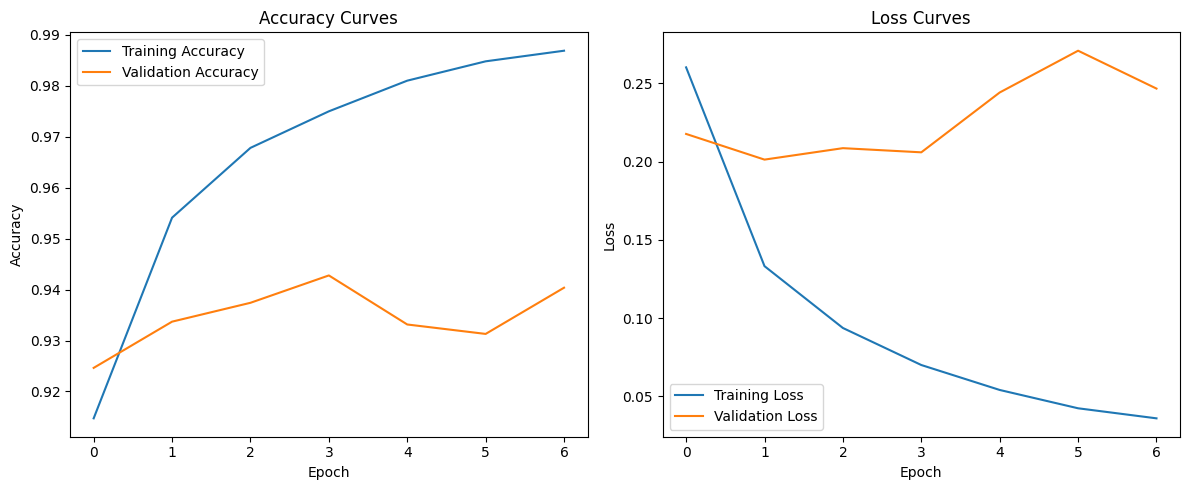

In [8]:
# Creating a pandas DataFrame from the training history
history_df = pd.DataFrame(history.history)

# Plotting the accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss curves
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation | Classification Report

In [9]:
from sklearn.metrics import classification_report

print("Generating predictions on the test set...")
predictions = model.predict(test_ds)

predicted_labels = np.argmax(predictions, axis=1)

# Generating and print the classification report
report = classification_report(y_test, predicted_labels, target_names=class_names)

print("\n--- Classification Report ---")
print(report)

Generating predictions on the test set...
338/338 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step

--- Classification Report ---
                      precision    recall  f1-score   support

          AnnualCrop       0.97      0.90      0.93       600
              Forest       0.95      0.98      0.97       600
HerbaceousVegetation       0.92      0.95      0.93       600
             Highway       0.91      0.92      0.91       500
          Industrial       0.97      0.96      0.97       500
             Pasture       0.92      0.91      0.91       400
       PermanentCrop       0.89      0.93      0.91       500
         Residential       0.96      0.99      0.97       600
               River       0.94      0.90      0.92       500
             SeaLake       0.99      0.97      0.98       600

            accuracy                           0.94      5400
           macro avg       0.94      0.94      0.94      5400
        weighted avg       0.94      0.94      0.94      5400



## Explainable AI (XAI) with Grad-CAM

In [16]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.output.shape)

0 input_layer_1 (None, 224, 224, 3)
1 resnet50v2 (None, 7, 7, 2048)
2 global_average_pooling2d (None, 2048)
3 dense (None, 128)
4 dense_1 (None, 10)


In [19]:
base_model = model.get_layer("resnet50v2")
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.output.shape)

0 input_layer (None, 224, 224, 3)
1 conv1_pad (None, 230, 230, 3)
2 conv1_conv (None, 112, 112, 64)
3 pool1_pad (None, 114, 114, 64)
4 pool1_pool (None, 56, 56, 64)
5 conv2_block1_preact_bn (None, 56, 56, 64)
6 conv2_block1_preact_relu (None, 56, 56, 64)
7 conv2_block1_1_conv (None, 56, 56, 64)
8 conv2_block1_1_bn (None, 56, 56, 64)
9 conv2_block1_1_relu (None, 56, 56, 64)
10 conv2_block1_2_pad (None, 58, 58, 64)
11 conv2_block1_2_conv (None, 56, 56, 64)
12 conv2_block1_2_bn (None, 56, 56, 64)
13 conv2_block1_2_relu (None, 56, 56, 64)
14 conv2_block1_0_conv (None, 56, 56, 256)
15 conv2_block1_3_conv (None, 56, 56, 256)
16 conv2_block1_out (None, 56, 56, 256)
17 conv2_block2_preact_bn (None, 56, 56, 256)
18 conv2_block2_preact_relu (None, 56, 56, 256)
19 conv2_block2_1_conv (None, 56, 56, 64)
20 conv2_block2_1_bn (None, 56, 56, 64)
21 conv2_block2_1_relu (None, 56, 56, 64)
22 conv2_block2_2_pad (None, 58, 58, 64)
23 conv2_block2_2_conv (None, 56, 56, 64)
24 conv2_block2_2_bn (None, 56, 

Analyzing image: /kaggle/input/dsdata/EuroSAT/River/River_943.jpg

Model's Focus (Heatmap):


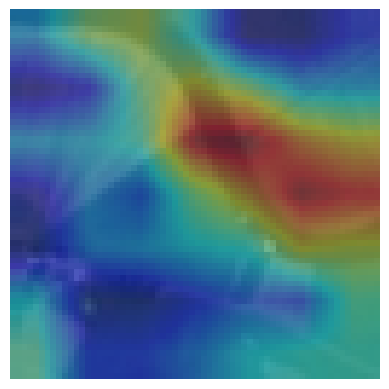

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Grad-CAM function 
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get the ResNet base
    base_model = model.get_layer("resnet50v2")

    # Feature extractor: from input -> last conv layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_model = tf.keras.Model(base_model.input, last_conv_layer.output)

    # Classifier: from conv output -> final predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    # Find layers after the feature extractor
    is_after_conv = False
    for layer in model.layers:
        if layer.name == "resnet50v2":
            is_after_conv = True
            continue
        if is_after_conv:
            x = layer(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Compute gradients
    with tf.GradientTape() as tape:
        last_conv_output = last_conv_model(img_array)
        tape.watch(last_conv_output)
        preds = classifier_model(last_conv_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()



# 1. Selecting a real image path from our test set
sample_path = X_test.sample(1, random_state=42).iloc[0]
print(f"Analyzing image: {sample_path}")

# 2. Preprocessing the image correctly for ResNetV2
img = tf.keras.utils.load_img(sample_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# Use the official ResNetV2 preprocessor
processed_img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)

# 3. Generating heatmap
heatmap = make_gradcam_heatmap(processed_img_array, model, "conv5_block3_out")

# 4. Overlaying heatmap on original image
original_img = cv2.imread(sample_path)
heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

# 5. Showing result
print("\nModel's Focus (Heatmap):")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

### Economic Opportunity Map

338/338 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step
Sample of Test Data with Opportunity Scores:


,filepath,true_label_int,predicted_label_int,predicted_class,opportunity_score
10476,/kaggle/input/dsdata/EuroSAT/AnnualCrop/Annual...,0,8,River,-1
26028,/kaggle/input/dsdata/EuroSAT/Industrial/Indust...,4,4,Industrial,3
23935,/kaggle/input/dsdata/EuroSAT/AnnualCrop/Annual...,0,0,AnnualCrop,0
19616,/kaggle/input/dsdata/EuroSAT/Forest/Forest_107...,1,1,Forest,-1
23408,/kaggle/input/dsdata/EuroSAT/Industrial/Indust...,4,4,Industrial,3


/tmp/ipykernel_36/2807120924.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


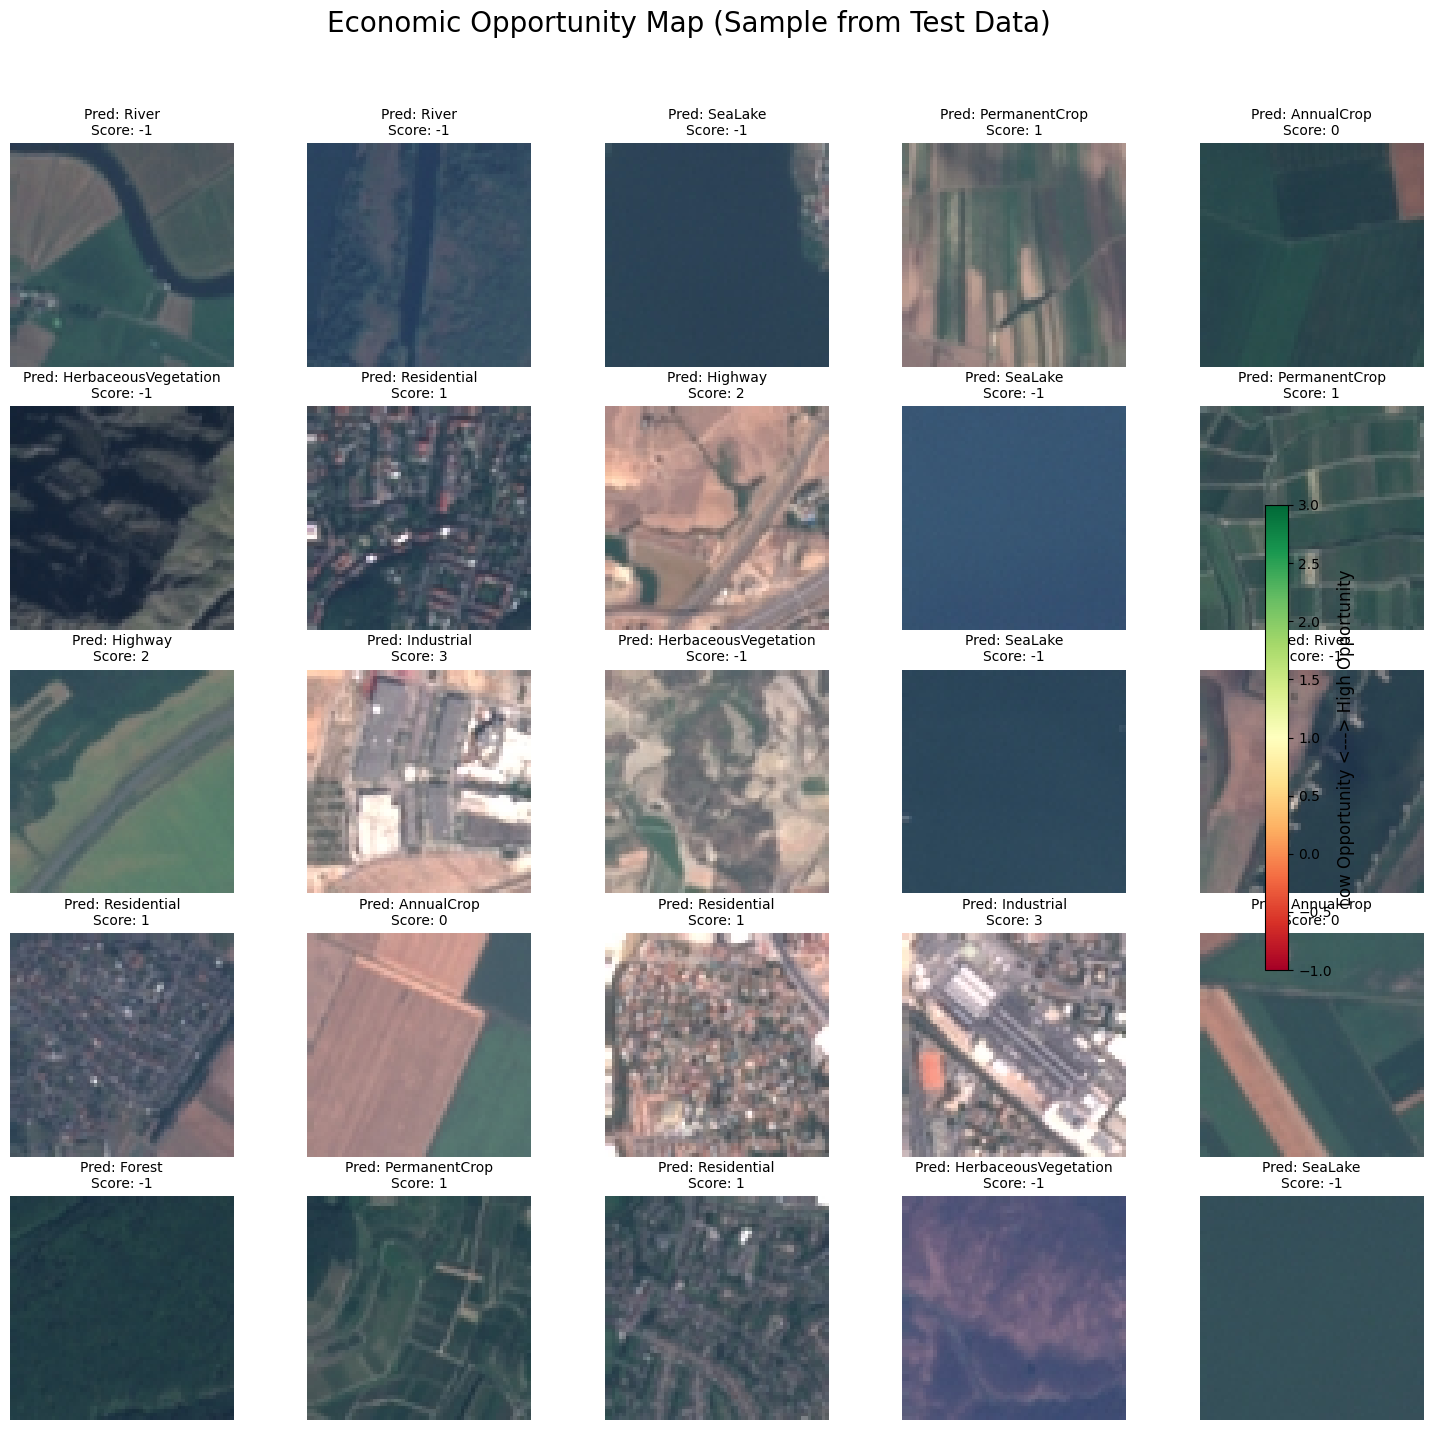

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

predictions = model.predict(test_ds)
predicted_label_ints = np.argmax(predictions, axis=1)

# Creating a DataFrame for our test results
df_test = pd.DataFrame({
    'filepath': X_test,
    'true_label_int': y_test,
    'predicted_label_int': predicted_label_ints
})

# Defining Our scoring system
# Higher scores indicate more economic opportunity
opportunity_scores = {
    'Industrial': 3,
    'Highway': 2,
    'Residential': 1,
    'PermanentCrop': 1,
    'AnnualCrop': 0,
    'Pasture': 0,
    'HerbaceousVegetation': -1,
    'Forest': -1,
    'River': -1,
    'SeaLake': -1
}

# Mapping the integer labels back to class names and then to scores
label_to_name = {i: name for i, name in enumerate(class_names)}
df_test['predicted_class'] = df_test['predicted_label_int'].map(label_to_name)
df_test['opportunity_score'] = df_test['predicted_class'].map(opportunity_scores)

print("Sample of Test Data with Opportunity Scores:")
display(df_test.head())

# Visualizing the Opportunity Map 
# We'll visualize a 5x5 grid (25 images) from our test set
sample_df = df_test.sample(25, random_state=42)

plt.figure(figsize=(15, 15))
plt.suptitle("Economic Opportunity Map", fontsize=20)

# Creating a colormap (Red -> Yellow -> Green)
cmap = plt.get_cmap('RdYlGn')
norm = Normalize(vmin=min(opportunity_scores.values()), vmax=max(opportunity_scores.values()))

for i, row in enumerate(sample_df.itertuples()):
    ax = plt.subplot(5, 5, i + 1)
    
    # Load and display the image
    img = tf.keras.utils.load_img(row.filepath)
    plt.imshow(img)
    
    # Get the color for the background based on the score
    score_color = cmap(norm(row.opportunity_score))
    ax.set_facecolor(score_color)
    
    # Add a title with the prediction
    plt.title(f"Pred: {row.predicted_class}\nScore: {row.opportunity_score}", fontsize=10)
    plt.axis("off")

# Adding a colorbar to serve as a legend
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gcf().get_axes(), orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Low Opportunity <---> High Opportunity', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()